In [1]:
import jax
from jax import random
from jax import numpy as jnp
import json
import mediapy
import optax
import os
import pickle
from PIL import Image

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import sys

sys.path.append('./')
sys.path.append('../')

from waymax import agents
from waymax import config as _config
from waymax import dynamics
from waymax import dataloader
from waymax import datatypes
from waymax import env as _env
from waymax import visualization

from flax.training.train_state import TrainState

import sys
sys.path.append('../')
sys.path.append('./')

from model.feature_extractor import KeyExtractor
from model.state_preprocessing import ExtractObs
from model.rnn_policy import ActorCriticRNN, ScannedRNN
from utils.viz import plot_observation_with_mask, plot_observation_with_goal

2024-02-06 16:39:55.856682: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 16:39:55.856724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 16:39:55.857751: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 16:39:56.783112: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
load_folder = '/data/draco/cleain/imitation_gap_waymax/logs'
expe_num = '20240111_183623'

with open(os.path.join(load_folder, expe_num, 'args.json'), 'r') as file:
    config = json.load(file)

n_epochs = 90

## Training Curves

In [4]:
with open(os.path.join(load_folder, expe_num, f'training_metrics_{n_epochs}.pkl'), 'rb') as file:
    training_dict = pickle.load(file)

In [5]:
# import jax.numpy as jnp
import numpy as np

X = np.arange(n_epochs)
losses = []

for e in range(n_epochs):
    losses.append(np.array(training_dict[e]['train']['loss']))

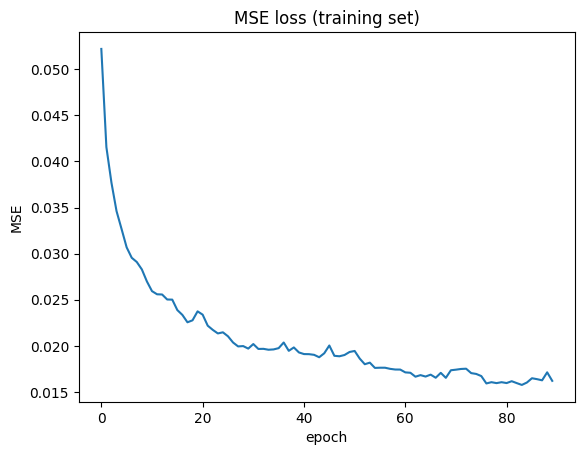

In [6]:
import matplotlib.pyplot as plt

plt.plot(X, losses)
plt.title('MSE loss (training set)')
plt.ylabel('MSE')
plt.xlabel('epoch');
# plt.ylim(0.1, 0.33);

In [7]:
X = np.arange(n_epochs)
log_div = []
overlap = []
offroad = []

for e in range(n_epochs):
    log_div.append(np.array(training_dict[e]['validation']['log_divergence']).mean())
    overlap.append(np.array(training_dict[e]['validation']['overlap']).mean())
    offroad.append(np.array(training_dict[e]['validation']['offroad']).mean())

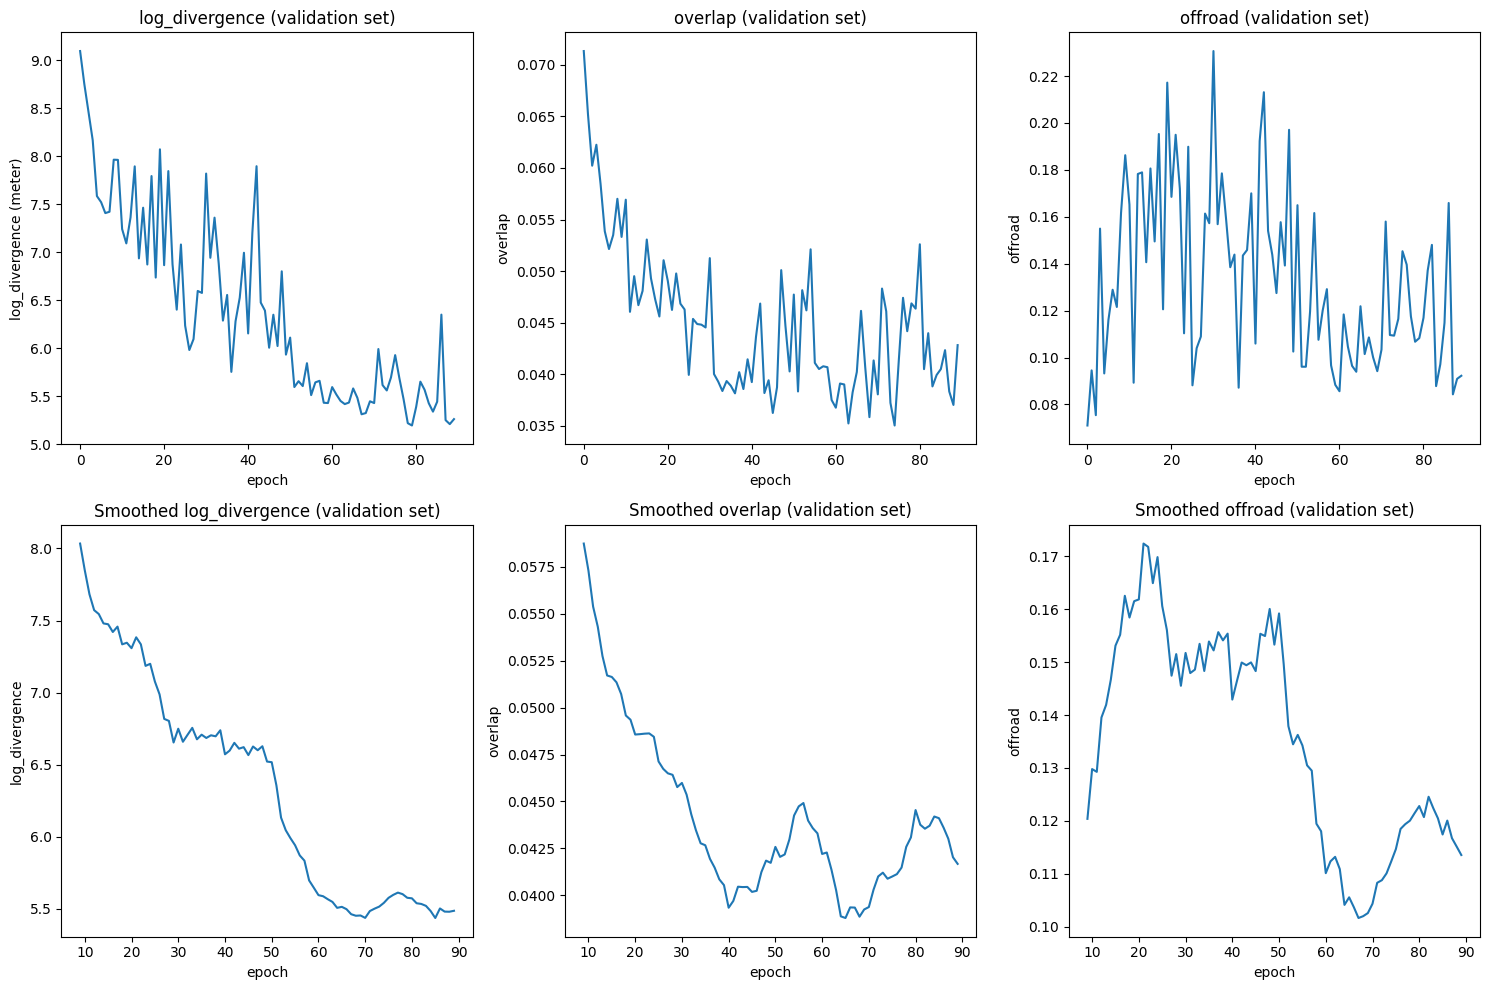

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))

fig.add_subplot(2,3,1)
plt.plot(X, log_div)
plt.title('log_divergence (validation set)')
plt.ylabel('log_divergence (meter)')
plt.xlabel('epoch');

fig.add_subplot(2,3,2)
plt.plot(X, overlap)
plt.title('overlap (validation set)')
plt.ylabel('overlap')
plt.xlabel('epoch');

fig.add_subplot(2,3,3)
plt.plot(X, offroad)
plt.title('offroad (validation set)')
plt.ylabel('offroad')
plt.xlabel('epoch');


window_size = 10

smoothed_log_div = np.convolve(log_div, np.ones(window_size) / window_size, mode='valid')
smoothed_overlap = np.convolve(overlap, np.ones(window_size) / window_size, mode='valid')
smoothed_offroad = np.convolve(offroad, np.ones(window_size) / window_size, mode='valid')

# Plotting the smoothed curves

fig.add_subplot(2, 3, 4)
plt.plot(X[window_size - 1:], smoothed_log_div)
plt.title('Smoothed log_divergence (validation set)')
plt.ylabel('log_divergence')
plt.xlabel('epoch')

fig.add_subplot(2, 3, 5)
plt.plot(X[window_size - 1:], smoothed_overlap)
plt.title('Smoothed overlap (validation set)')
plt.ylabel('overlap')
plt.xlabel('epoch')

fig.add_subplot(2, 3, 6)
plt.plot(X[window_size - 1:], smoothed_offroad)
plt.title('Smoothed offroad (validation set)')
plt.ylabel('offroad')
plt.xlabel('epoch')

plt.tight_layout()
plt.show()


## Learned policy

In [4]:
config['num_envs_eval'] = 1

In [5]:
WOD_1_1_0_VALIDATION = _config.DatasetConfig(
    path=config['validation_path'],
    max_num_rg_points=config['max_num_rg_points'],
    data_format=_config.DataFormat.TFRECORD,
    max_num_objects=config['max_num_obj'],
)

data_iter = dataloader.simulator_state_generator(config=WOD_1_1_0_VALIDATION)
id = 0

In [6]:
scenario = next(data_iter)
id += 1

print('Has SDC:', jnp.any(scenario.object_metadata.is_sdc))

Has SDC: True


In [7]:
bicycle_dynamics_model = dynamics.InvertibleBicycleModel()
planning_dynamics_model = _env.PlanningAgentDynamics(bicycle_dynamics_model)

# Env config
env_config = _config.EnvironmentConfig(
    controlled_object=_config.ObjectType.SDC,
    max_num_objects=config['max_num_obj']
)
env = _env.PlanningAgentEnvironment(
            dynamics_model=bicycle_dynamics_model, # /!\ NOT the planning_dynamic_model otherwise repetition
            config=env_config,
            )

# DEFINE EXPERT AGENT
expert_agent = agents.create_expert_actor(planning_dynamics_model)

In [8]:
extractors = {
    'ExtractObs': ExtractObs
}
feature_extractors = {
    'KeyExtractor': KeyExtractor
}

extractor = extractors[config['extractor']](config)
feature_extractor = feature_extractors[config['feature_extractor']]
feature_extractor_kwargs = config['feature_extractor_kwargs']

network = ActorCriticRNN(bicycle_dynamics_model.action_spec().shape[0],
                            feature_extractor_class=feature_extractor ,
                            feature_extractor_kwargs=config['feature_extractor_kwargs'])

feature_extractor_shape = config['feature_extractor_kwargs']['final_hidden_layers']

init_rnn_state = ScannedRNN.initialize_carry((config["num_envs"], feature_extractor_shape))
rng, _rng = jax.random.split(random.PRNGKey(config['key']))

init_x = extractor.init_x()
# network_params = network.init(_rng, init_rnn_state, init_x)

tx = optax.chain(
    optax.clip_by_global_norm(config["max_grad_norm"]),
    optax.adam(config["lr"], eps=1e-5),
)

with open(os.path.join(load_folder, expe_num, f'params_{n_epochs}.pkl'), 'rb') as file:
    params = pickle.load(file)

train_state = TrainState.create(apply_fn=network.apply,
                                params=params,
                                tx=tx,
                                )

In [9]:
from typing import NamedTuple

class Transition(NamedTuple):
    done: jnp.ndarray
    expert_action: jnp.array
    obs: jnp.ndarray

init_rnn_state_eval = ScannedRNN.initialize_carry((config["num_envs_eval"], feature_extractor_shape))

def _log_step(current_state, unused):

    done = current_state.is_done
    obsv = extractor(current_state)

    transition = Transition(done,
                            None,
                            obsv
    )

    # Update the simulator with the log trajectory
    current_state = datatypes.update_state_by_log(current_state, num_steps=1)

    return current_state, transition

def extand(x):
    if isinstance(x, jnp.ndarray):
        return x[:, jnp.newaxis, ...]
    else:
        return x

In [ ]:
# INIT ENV
current_state = env.reset(scenario)

# Compute the rnn_state on first env.config.init_steps from the log trajectory 
_, log_traj_batch = jax.lax.scan(_log_step, scenario, None, env.config.init_steps - 1)
rnn_state, _, _ = network.apply(train_state.params, init_rnn_state_eval, (jax.tree_map(extand, log_traj_batch.obs), log_traj_batch.done[:, jnp.newaxis, ...]))


In [ ]:
imgs = []
scenario_metrics = {'log_divergence': [],
                    'overlap': [],
                    'offroad': []}

current_state = env.reset(scenario)

step = 0
while not current_state.is_done:
    step += 1
    
    done = jnp.tile(current_state.is_done, (1,))
    obsv = extractor(current_state)
    
    # Add a mask here
    
    rnn_state, data_action, _ = network.apply(train_state.params, rnn_state, (jax.tree_map(extand, obsv), done[:, jnp.newaxis, ...]))
    action = datatypes.Action(data=data_action[0, 1], valid=jnp.ones((1), dtype='bool'))


    sdc_obs = datatypes.sdc_observation_from_state(current_state,
                                                   roadgraph_top_k=20000)
    img = plot_observation_with_goal(sdc_obs,
                                     obj_idx=0,
                                     goal=obsv['proxy_goal'][0, 0])
    imgs.append(img)
    
    current_state = env.step(current_state, action)
    
    metric = env.metrics(current_state)

    for key, value in metric.items():
        if value.valid:
            scenario_metrics[key].append(value.value)


In [ ]:
print(f'Metrics on ex n_{id} for the validation dataset \n')
for key, value in scenario_metrics.items():
    print(f'{key}: {jnp.array(value).mean()} \n')

In [78]:
# Save as gif 
frames = []

for img in imgs:
    pil_img = Image.fromarray(img)
    frames.append(pil_img)

save_animation_folder = '../animation'

ex_saving_path = os.path.join(save_animation_folder, expe_num)
# os.mkdir(ex_saving_path)

# Save the frames as a GIF
frames[0].save(os.path.join(ex_saving_path, f'ex_{id}.gif'), save_all=True, append_images=frames[1:], duration=100, loop=0)

## Ground truth

In [ ]:
state = scenario

imgs = []
for _ in range(scenario.remaining_timesteps):
  state = datatypes.update_state_by_log(state, num_steps=1)
  imgs.append(visualization.plot_simulator_state(state, use_log_traj=True))

mediapy.show_video(imgs, fps=10)